In [1]:
import cdsapi
import pandas as pd
import xarray as xr
from shapely import geometry
from pathlib import Path
from typing import Union
from datetime import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from phase_o_matic.preprocess import get_vapor_partial_pressure, convert_pressure_to_pascals, interpolate_to_heights

from scipy import integrate

from era import initconst
constants = initconst()

In [2]:
import numpy as np
levels = ['1','2','3','5','7','10','20','30','50', '70','100','125',\
    '150','175','200','225', '250','300','350','400','450','500','550','600','650',\
    '700','750','775','800','825', '850','875','900','925','950','975','1000']
levels = np.array(levels).astype('int32')
lats = np.linspace(43, 45, 9).astype('float32')
lons = np.linspace(-116, -115, 10).astype('float32')
ds = xr.Dataset(
    {
        'z': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32'), {'units':'m**2 s**-2', 'long_name':'Geopotential', 'standard_name' :'geopotential'}),
        't': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32'), {'units' :'K', 'long_name' :'Temperature', 'standard_name' :'air_temperature'}),
        'q': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32'), {'units' :'kg kg**-1', 'long_name' :'Specific humidity', 'standard_name' :'specific_humidity'}),
        'vpr': (['longitude', 'latitude','level','time'], np.random.random((10, 9, 37, 1)).astype('float32')),
    },  
    coords = {
        "longitude" : (["longitude"], lons, {'units' :'degrees_east', 'long_name' :'longitude'}),
        "latitude" : (["latitude"], lats, {'units' :'degrees_north', 'long_name' :'latitude'}),
        "level" : (["level"], levels, {'units' :'millibars', 'long_name' :'pressure_level'}),
        "time" : (["time"], [pd.to_datetime('2020-01-04T09:00')], {'long_name' :'time'}),
    },
    attrs={'Conventions' :'CF-1.6', 'history' :'2023-05-04 17:03:14 GMT by grib_'}
)

In [3]:
era = xr.open_dataset('../data/ERA5_2020-01-03T20:00_-116.0_45.0_-115.0_46.0.nc')
era = convert_pressure_to_pascals(era)
era = get_vapor_partial_pressure(era)
ds = interpolate_to_heights(era)
ds = ds.isel(latitude = slice(0, 3))

In [4]:
def calculate_dry_refractivity(dataset: xr.Dataset) -> xr.Dataset:
    """
    Calculate dry refractivity from air pressure, vapor pressure, and temperature
    
    Args:
    dataset: xarray dataset with air_pressure, vapor_pressure, and temperature

    Returns:
    dataset: xarray dataset with dry refractivity added
    """

    assert dataset['air_pressure'].attrs['units'] == 'pascals'
    assert dataset['temperature'].attrs['units'] == 'K'
    
    # constant for dry refractivity
    k1 = 0.776 # K Pa^-1
    
    # calculate dry refractivity. Reference: https://www.itu.int/dms_pubrec/itu-r/rec/p/R-REC-P.453-11-201507-S!!PDF-E.pdf
    dataset['N_dry'] = k1 * (dataset['air_pressure'] - dataset['vapor_pressure']) / dataset['temperature']

    return dataset

def calculate_wet_refractivity(dataset: xr.Dataset) -> xr.Dataset:
    """
    Calculate wet refractivity from vapor pressure, and temperature
    
    Args:
    dataset: xarray dataset with air_pressure, vapor_pressure, and temperature

    Returns:
    dataset: xarray dataset with wet refractivity added
    """

    assert dataset['vapor_pressure'].attrs['units'] == 'pascals'
    assert dataset['temperature'].attrs['units'] == 'K'

    # constants for wet refractivity
    k2 = 0.716 # K Pa^-1
    k3 = 3750 # K^2 Pa^-1

    # calculate wet refractivity. Reference: https://www.itu.int/dms_pubrec/itu-r/rec/p/R-REC-P.453-11-201507-S!!PDF-E.pdf
    dataset['N_wet'] = k2 * dataset['vapor_pressure'] / dataset['temperature'] + k3 * dataset['vapor_pressure'] / dataset['temperature']**2

    return dataset

def integrate_refractivity(dataset: xr.Dataset) -> xr.Dataset:
    """
    Integrate combined refractivity through atmosphere from high to low.
    
    Args:
    dataset: xarray dataset with combined refractivity and heights (m)

    Returns:
    dataset: xarray dataset with cumulative integrated refractivity added
    """
    # check if heights are increasing
    if np.all(np.diff(dataset.height, 1) > 0):
        # reverse heights so we integrate from satellite to ground (high -> low)
        dataset = dataset.reindex(height=list(reversed(dataset.height)))
    # calculate integrated refractivity index from high to low at each lat, long
    integrated_N = integrate.cumtrapz(dataset['N'], x = dataset['height'])
    # get first value to pad integration from highest and next highest value
    start_val = 2*integrated_N[:, :, :, 0] - integrated_N[:, :, :, 1]
    # insert as new variable cumulative refractivity index
    dataset['cum_N'] = (['time', 'longitude', 'latitude', 'height'], np.insert(integrated_N, 0, start_val, -1))

    return dataset

def calculate_refractive_indexes(dataset: xr.Dataset, wavelength: float = 0.23) -> xr.Dataset:
    """
    Calculate dry and wet refractivity from air pressure, vapor pressure, and temperature.
    Integrate refractivity through atmosphere from high to low.
    
    Args:
    dataset: xarray dataset with air_pressure, vapor_pressure, and temperature

    Returns:
    dataset: xarray dataset with dry, wet, combined, and integrated refractivity
    """

    # calculate the refractive index from air pressure
    dataset = calculate_dry_refractivity(dataset)
    # calculate refractivity index from water vapor
    dataset = calculate_wet_refractivity(dataset)
    # combine wet and dry refractivity
    dataset['N'] = dataset['N_dry'] + dataset['N_wet']
    # calculate integrated refractivity index from high to low
    dataset = integrate_refractivity(dataset)
    # calculate integrated atmospheric phase delay through atmosphere
    dataset['atm_phase'] = -4 * np.pi / wavelength * 1.0e-6 *  dataset['cum_N']

    return dataset


In [5]:
ds = calculate_refractive_indexes(ds)

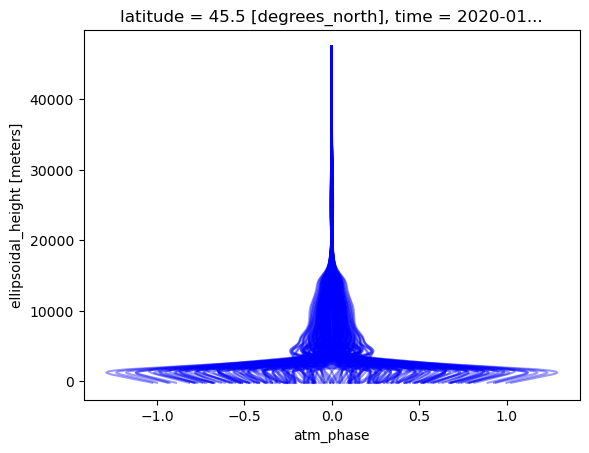

In [6]:
from itertools import product
fig, ax = plt.subplots()
for i, j in product(range(3), range(5)):
    for k, l in product(range(3), range(5)):
        if i == k and j == l:
            continue
        (ds['atm_phase'].isel(time = 0, latitude = k, longitude = l) - ds['atm_phase'].isel(time = 0, latitude = i, longitude = j)).plot(y = 'height', color = 'blue', alpha = 0.4)

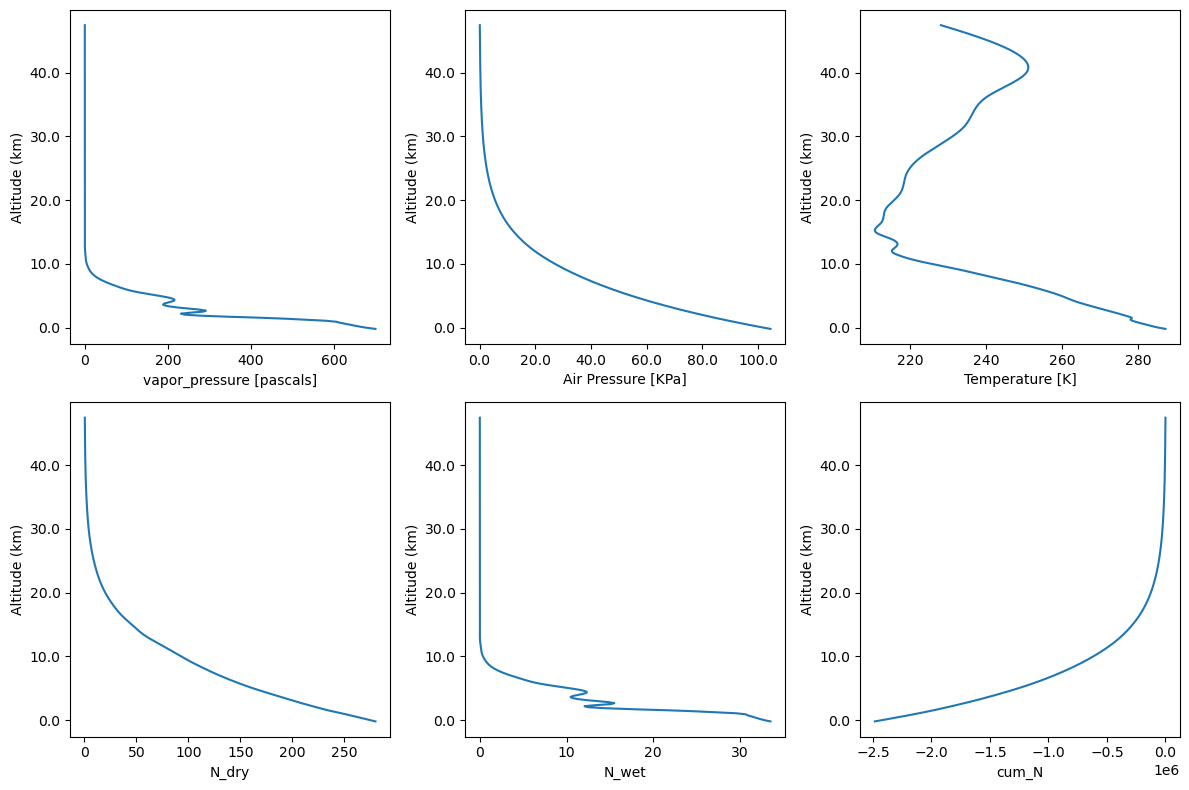

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (12, 8))

ds['vapor_pressure'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 0], y = 'height')
ds['air_pressure'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 1], y = 'height')
ds['temperature'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[0, 2], y = 'height')
ds['N_dry'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 0], y = 'height')
ds['N_wet'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 1], y = 'height')
ds['cum_N'].isel(time = 0, latitude = 0, longitude = 0).plot(ax = axes[1, 2], y = 'height')

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here
for ax in axes.ravel():
    ax.yaxis.set_major_formatter(yfmt)
    ax.set_ylabel('Altitude (km)')
    ax.set_title('')

axes[0, 1].xaxis.set_major_formatter(yfmt)
axes[0, 1].set_xlabel('Air Pressure [KPa]')
# axes[1,2].set_xscale('log')
plt.tight_layout()